<h1 style="color:blue; text-align:center">ToF-SIMS data visualizer</h1>

<h2 style="color:brown; text-align:center">Library dependencies</h2>

In [203]:
import matplotlib
import matplotlib.pyplot as plt
import glob
from statistics import mean
import re
import numpy as np
import csv
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go


<h2 style="color:brown; text-align:center">Plot font properties</h2>

In [204]:
# --- Font size and familiy
matplotlib.rcParams['font.size']          =   10
matplotlib.rcParams['axes.labelsize']     =   10
matplotlib.rcParams['font.serif']         =   ["Cambria"]
matplotlib.rcParams['font.sans-serif']    =   ["Arial"]
#matplotlib.rcParams['axes.unicode_minus'] =   False # Use for Noto Fonts

matplotlib.rcParams["mathtext.fontset"]   =    "dejavusans" # "dejavusans" "dejavuserif" "stix"
# --- Axes/borders on the plot sides
matplotlib.rcParams['axes.linewidth']     =   1
matplotlib.rcParams['lines.linewidth']    =   .9

theme_color_code = {'primary': '#0275d8', 'success': '#5cb85c', 'info': '#5bc0de', 'warning': '#f0ad4e', 
                    'danger': '#d9534f', 'inverse': '#292b2c', 'gray': '#a3a3a3', 'plain': '#ffffff'}


<h2 style="color:brown; text-align:center">ToF-SIMS data processing parameters</h2>

<p style="font-size: 16px"> Enter the ToF-SIMS file name that you are intended to process through this script. Enter your filename within the inverted quotation after equal to of `filename_to_process`<br>
</p>
<strong>A general note, please do not modify/remove inverted quotation or square bracket or curly braces anywhere, (Sensitive for python) unless you know the purpose of changing. Feel free to change the values inside them to fulfil your needs. <br> And keep the jupyter notebook in the same directory containing the ToF-SIMS results you are interested to process them. </strong>

<p style="font-size: 16px"> Enter one sample element you are sure that is available in the ToF-SIMS file. <br>
By default, use 'H+', because it will be present in the most of the ToF-SIMS results. If that is not the case, please update accordingly. </p>

<p style="color: red"> And if your ToF-SIMS was performed in negative mode, please change the symbols accordingly to match the exact symbols displayed in your ToF-SIMS file. (Hint: All elements will be represented in negative)
</p>

In [205]:
filename_to_process = 'ISG_pH9_10 jours_POS_Depth_Oct1802.TXT'
one_sample_element = 'H+'

<p style="font-size: 16px"> 
Choose the list of elements that you are intend to plot in primary y axis and secondary y-axis. Each element has to be chosen from the symbols as follows: <br><br>
    <strong>'H+', '6Li+', 'Li+', '10B+', 'B+', 'Ca++', 'Na+', 'Al+' , 'Si+', '29Si+', '30Si+', 'K+', 'NaO+', 'Ca+', '41K+', 'AlO+', '44Ca+', 'Na_2+', 'Zr+'.</strong> <br><br>
Note: If you don't see the element of your interest in the plot, please check the symbol represented in the ToF-SIMS file for the element of your interest.</p> <p style="color: red"> And if your ToF-SIMS was performed in negative mode, please change the symbols accordingly to match the exact symbols displayed in your ToF-SIMS file. (Hint: All elements will be represented in negative)
</p>

<p>Note: Do not leave the list_of_elements_to_plot_in_primary_y_axis to be empty. You can leave list_of_elements_to_plot_in_secondary_y_axis to be empty if no elements are to be displayed there.</p>


In [336]:
list_of_elements_to_plot_in_primary_y_axis = ['Zr+']
list_of_elements_to_plot_in_secondary_y_axis = []


<p style="font-size: 16px"> 
Choose the way your SIMS data to be processed. <br><br>
<strong> Options: </strong><br><br>
<strong>'raw_data'</strong> = Visualize the intensity for each chosen element without processing the data.<br>
<strong>'mean_normalized'</strong> = visualization based on mean normalization with respect to the pristine glass. <br>
<strong>'ratio_of_element'</strong> = Visualize the ratio of raw intensity between the two elements. Choice of the elements has to be declared in 'ratio_of_element_numerator' and 'ratio_of_element_denominator'.<br>
<strong>'element_normalized'</strong> = Choose this option if you want to normalize each of your chosen elements to be normalized with respect to any particular element, for instance Zirconium normalization. Choice of the element to normalize has to be defined at 'choose_element_to_normalize', which you will find in subsequent steps. <br>
</p>

<p style="font-size: 16px">Examples:
    <li>If I would like to perform only mean normalization, then I will set the script as:</li>
type_of_plot = ['mean_normalized']
    <li>If I would like to perform mean normalization with isotopic ratio for any two elements of my choice:</li>
type_of_plot = ['mean_normalized', 'ratio_of_element']
    <li>If I would like to perform only the element normalization:</li>
type_of_plot = ['element_normalized']
    <li>If I would like to perform the element normalization with isotopic ratio for any two elements of my choice:</li>
type_of_plot = ['element_normalized', 'ratio_of_element']
<br>
Likewise, you can choose 'raw_data' or 'mean_normalized' or 'element_normalized' as your first parameter in the type_of_plot. Optionally you can include 'ratio_of_element' if you are interesting calculating the isotopic ratio.
</p><br>


In [337]:
type_of_plot = ['mean_normalized', 'ratio_of_element']

<p>If you choose the option of 'mean_normalized' in previous line, then you will have to define the glass region. It can be handled in two ways. <br>
<strong>Options:</strong><br>
<strong>start_end</strong> = You will have choice to define the glass region manually the starting and ending point <br>
<strong>partition</strong> = 
    You will define the partition of the glass to which the normalization has to be performed, whether it is based on first few layers or last few layers. In both the cases, you will have ability to choose the number of layers of pristine glass. <br>
</p>


In [338]:
type_of_mean_normalization = 'partition'

<p>If you choose start_end option in type_of_mean_normalization:<br>
Explanation:
pristine_glass_start_region = Define the point at which you are intend to consider the region as start of pristine glass and for computing the mean.
pristine_glass_end_region = Define the point at which you are intend to consider the region as end of pristine glass and for computing the mean.
<p style="color:red">Note: When you are defining the start and end region of pristine glass in (nm), the values will not be exactly the same in the ToF-SIMS file. To handle this issue, i have prepared my script to find the closest value from what you have mentioned. For instance, if you define </p>
</p>

In [339]:
pristine_glass_start_region = 100
pristine_glass_end_region = 140

<p>If you choose 'partition' option in type_of_mean_normalization:
Explanation:
mean_normalize_based_on_which_partition = Choose the option to represent if you consider that pristine glass is in starting or ending. In other words, define if you want to mean normalize based on last few layers or first few layers.
    <br>
    <strong>Options:</strong>
<li>'last' = Mean will be computed for last few layers</li>
<li>'first' = Mean will be computed for top few layers</li>
</p>
<p>By default, set 'mean_normalize_based_on_which_partition' as 'last', since the gel comes first and pristine glass is last few layers. </p>

<p>
    Next parameter is 'mean_normalize_based_on_number_of_layers': <br> Set its value in Integer, which directly defines the depth in (nm) that you consider as pristine glass to perform mean normalization. <br>
</p>

<p style="font-size: 16px">Examples:
    <li>If I would like to define the script that my glass region is from last 30 nm depth of ToF-SIMS data, then I will do as follows</li>
mean_normalize_based_on_which_partition = 'last'<br>
mean_normalize_based_on_number_of_layers = 30
    <li>If I would like to define the script that my glass region is based on last 100 nm depth of ToF-SIMS data, then I will do as follows</li>
mean_normalize_based_on_which_partition = 'last'<br>
mean_normalize_based_on_number_of_layers = 100
<br>
    <li>If I would like to define the script that my glass region is based on first 40 nm depth of ToF-SIMS data, then I will do as follows</li>
mean_normalize_based_on_which_partition = 'first'<br>
mean_normalize_based_on_number_of_layers = 40
<br>

Note that, the integer you are defining is the value in nanometer. Since ToF-SIMS does not have the depth defined in Integer, python will try to find the closest value as possible to the one you define. In any case, at the end of the script you will know from which layer to which layer the pristine glass is considered to perform the mean normalization. 
</p><br>


In [340]:
mean_normalize_based_on_which_partition = 'last'
mean_normalize_based_on_number_of_layers = 30


<p>If you choose element_normalized option in type_of_plot:
    You need to define the element to which you need all other elements to be normalized against. For instance, All the elements of your choice will be normalized against the Zirconium.<br>
    Please note that, you need to define the name of the element according to the naming convention followed in your ToF-SIMS file. 
</p>

In [341]:
choose_element_to_normalize = 'Zr+'

<p>If you included the option of 'ratio_of_element' in 'type_of_plot', then you will have to define some of the parameters to achieve your goal. <br>
<strong>Parameters to declare:</strong><br>
<strong>ratio_of_element_numerator</strong> = Choose the element of your choise for numerator to calculate the ratio. For example, if you want to estimate the ratio between O18/O16, you have to declare the symbol of O18 here. Note: Symbol has to be declared as per naming convention followed in your ToF-SIMS file. <br>
<strong>ratio_of_element_denominator</strong> = Choose the element of your choise for denominator to calculate the ratio. For example, if you want to estimate the ratio between O18/O16, you have to declare the symbol of O16 here. Note: Symbol has to be declared as per naming convention followed in your ToF-SIMS file. <br>
<strong>axis_of_ratio_of_element_to_plot</strong> = Choose between the options 'primary' or 'secondary' to create plot for the ratio of two elements chosen below, along the primary y-axis or secondary y-axis. <br>
</p>


In [342]:
ratio_of_element_numerator = '^10B+'
ratio_of_element_denominator = 'B+'
axis_of_ratio_of_element_to_plot = 'secondary'
adjust_elemental_ratio_to_natural_abundance = 'yes'
natural_abundance_of_ratio = 0.2

<h2 style="color:brown; text-align:center">ToF-SIMS data visualized parameters</h2>

<p style="font-size: 16px"> 
Give the title that you are intend to choose for the plot under title_of_the_plot. Title has to be given within the inverted comma. <br> Place \n symbol if you want to have a line break in your title. <br> If you are trying to visualize multiple plots and each need to have the title with its corresponding filename at the end, you can change this in 'type_of_title'. <br><br><br>
<strong> Options of type_of_title: </strong><br><br>
<strong> 'with_filename' </strong> = Whatever the title you type, at the end of it, ToF-SIMS input filename will be added in the plot title. <br>
<strong> 'without_filename' </strong> = Whatever the title you type in title_of_the_plot, it will be displayed as such.

</p>




In [382]:
type_of_title = 'without_filename'
title_of_the_plot = 'Intensities mean normalized with respect to the pristine glass'

#### Choose the position of the legend to be placed
#### Options:
#### 0 = best (Automatically finds the best position); 1 = upper right; 2 = upper left; 3 = lower left; 4 = lower right; 5 = right; 6 = center left; 7 = center right; 8 = lower center; 9 = upper center; 10 = center


In [383]:
primary_legend_pos = 0
secondary_legend_pos = 4

#### Based on Zr profile, Choose number of layers to cut from the starting. If you choose 0, no layers are removed, 1 will remove only top 1 layer and so on.

In [384]:
number_of_layers_to_cut = 0

<h2 style="color:brown; text-align:center">Customizing the properties and labels of the plot</h2>

#### Give the labels that you are intend to choose for the x_axis and y_axis. Label has to be given within the inverted quotation.

In [385]:
primary_x_axis_label = 'Depth (nm)'
primary_y_axis_label = '$1^{o}$ Intensity'
secondary_y_axis_label = '$2^{o}$ Intensity'

primary_yaxis_legend_title = '$1^{o}$ y-axis'
secondary_yaxis_legend_title = '$2^{o}$ y-axis'

#### If you want to change the color of the grid, you can choose the color of your choice
<p>There are some themes i have set in built, so you can simply choose one of them to customize the color of the grid.
The available themes are: <p style="color:green;">'primary', 'success', 'info', 'warning', 'danger', 'inverse', 'gray', 'plain' </p>
'plain' can be set if you want to remove the grid completely from the plot.
You can customize the opacity of the plot from 0.1 to 1 in 'grid_opacity' parameter.
</p>

In [386]:
theme_color = 'gray'
grid_opacity = 0.1

<p>
To customize the style of the lines for the primary axis data and secondary axis data individually, declare it below under the 'primary_axis_plot_linestyles' and 'secondary_axis_plot_linestyles'. 
The following linestyles options are available.
    <li>'solid'</li>
    <li>'dotted'</li>
    <li>'dashed'</li>
    <li>'dashdot'</li>
</p>

<p>
In some cases, the plot y-axis range coming by default is not the target of your analysis, in such cases you have an option to define the range from which y-axis should start and end in below line. 
    <li>primary_axis_y_limit = [start, end]</li>
    <li>secondary_axis_y_limit = [start, end]</li>
    
       If you want python to select the range by itself based on the range of data, leave the square bracket empty as shown below. 
</p>

<p>
    <li style="color:green">primary_axis_y_limit = [ ]</li>
    <li style="color:green">secondary_axis_y_limit = [ ]</li>
    
    I left empty square bracket for 'secondary_axis_y_limit' and defined start and end region for the 'primary_axis_y_limit' in the below cell, use that as reference as you wish.
</p>

In [387]:
primary_axis_plot_linestyles = 'solid'
secondary_axis_plot_linestyles = 'dotted'
primary_axis_y_limit = [0.0, 1.7]
secondary_axis_y_limit = [0.0, 22]
primary_axis_x_limit = [0.0, 100]


<p>
If you want to customize your plot beyond the available options given here, I allow you to export the processed data right before the data being visualized. This will help you avoid doing math to process the data or mean normalize or element normalize. So you will get the output directly for the selected atoms, with normalization parameters you have selected. The file will be stored in the form of '.csv', and the filename will follow a specific pattern as below:
</p>
<p>your_tofsims_filename + type of normalization + 'processed'.csv</p>
For instance, if my tofsims input filename is 'tofsims_ph9.txt', and i process the 'element_normalization' method, the filename will be as follows:
<p style="color:green;">tofsims_ph9_element_processed.txt</p>
If you choose mean_normalization, you will see 'mean' in the place of 'element'.
If you choose raw_data as type_of_plot, you will see 'raw' in the place of 'element'.


In [388]:
export_data = 'yes'

In [389]:
interactive_mode = 'yes'

In [390]:
pilot_mode = 'no'

<h2 style="color:brown; text-align:center">Define functions</h2>

In [393]:
def tof_sims_file_process(filepath):
    x1_1 = open(filepath).readlines()
    file_name = filepath.strip('.TXT')
    depth = []
    dict_all_elements_raw_p2p = {}
    dict_all_elements_raw_p2p_secondary = {}
    dict_all_elements_raw_p2p_ratio = {}
    dict_all_elements_raw_p2p_element_to_norm = {}
    list_of_elements_in_file = []
    for lines1_1 in x1_1:
        r23 = re.search(r'inf', lines1_1)
        if not r23:
            r1 = re.search(r'%s' %(one_sample_element), lines1_1)
            if r1:
                for lines1_22 in (lines1_1.strip('#').split()):
                    list_of_elements_in_file.append(lines1_22)
            if lines1_1[0] != '#':
                dot_formatted = (lines1_1.replace(',', '.'))
                splitted = (dot_formatted.split())
                depth.append(float(splitted[0]))
                if list_of_elements_to_plot_in_primary_y_axis != []:
                    for lines1_23 in list_of_elements_to_plot_in_primary_y_axis:
                        position_of_each_atom = ((list_of_elements_in_file.index(lines1_23) + 1)*2)
                        dict_all_elements_raw_p2p.setdefault('%s' %(lines1_23), []).append(float(splitted[position_of_each_atom]))
                if list_of_elements_to_plot_in_secondary_y_axis != []:
                    for lines1_24 in list_of_elements_to_plot_in_secondary_y_axis:
                        position_of_each_atom = ((list_of_elements_in_file.index(lines1_24) + 1)*2)
                        dict_all_elements_raw_p2p_secondary.setdefault('%s' %(lines1_24), []).append(float(splitted[position_of_each_atom]))
                for lines1_25 in [ratio_of_element_numerator, ratio_of_element_denominator]:
                    position_of_each_atom = ((list_of_elements_in_file.index(lines1_25) + 1)*2)
                    dict_all_elements_raw_p2p_ratio.setdefault('%s' %(lines1_25), []).append(float(splitted[position_of_each_atom]))
                for lines1_26 in [choose_element_to_normalize]:
                    position_of_each_atom = ((list_of_elements_in_file.index(lines1_26) + 1)*2)
                    dict_all_elements_raw_p2p_element_to_norm.setdefault('%s' %(lines1_26), []).append(float(splitted[position_of_each_atom]))
                
    return {'file_name': file_name, 'depth': depth, 'primary_axis_elements': dict_all_elements_raw_p2p, 
            'secondary_axis_elements': dict_all_elements_raw_p2p_secondary, 'ratio_of_elements': dict_all_elements_raw_p2p_ratio,
            'element_to_normalize': dict_all_elements_raw_p2p_element_to_norm
           }

def filename_designer():
    if 'raw_data' in type_of_plot:
        return 'raw'
    elif 'mean_normalized' in type_of_plot:
        return 'mean'
    elif 'element_normalized' in type_of_plot:
        return 'element'

def write_data_as_file(data_in_dict):
    file_name = data_in_dict.get('file_name')
    only_depth = {}
    only_depth['depth'] = data_in_dict.get('depth')
    if list_of_elements_to_plot_in_primary_y_axis != []:
        primary_axis_data = data_in_dict.get('primary_axis_elements')
        all_data_compiled = {k: v for d in [only_depth,primary_axis_data] for k, v in d.items()}
    if list_of_elements_to_plot_in_secondary_y_axis != []:
        secondary_axis_data = data_in_dict.get('secondary_axis_elements')
        all_data_compiled = {k: v for d in [all_data_compiled,secondary_axis_data] for k, v in d.items()}
    with open("%s_%s_processed.csv" %(file_name, filename_designer()), "w", encoding='UTF8', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(all_data_compiled.keys())
        writer.writerows(zip(*all_data_compiled.values()))
    
def tof_sims_data_plot_interactive(data_in_dict):
    depth = data_in_dict.get('depth')
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    if 'primary_axis_elements' in data_in_dict.keys():
        prim_df = pd.DataFrame.from_dict(data_in_dict.get('primary_axis_elements'))
        prim_df.insert(0, 'Depth', depth)
        for lines6_1, lines6_2 in data_in_dict.get('primary_axis_elements').items():
            fig.add_trace(
                go.Scatter(
                    x = prim_df['Depth'],
                    y = prim_df[lines6_1], name=lines6_1, visible = True
                ),
                secondary_y=False,
            )
    if 'secondary_axis_elements' in data_in_dict.keys():
        second_df = pd.DataFrame.from_dict(data_in_dict.get('secondary_axis_elements'))
        second_df.insert(0, 'Depth', depth)
        for lines6_1, lines6_2 in data_in_dict.get('secondary_axis_elements').items():
            fig.add_trace(
                go.Scatter(
                    x = second_df['Depth'],
                    y = second_df[lines6_1], name=lines6_1, visible = True
                ),
                secondary_y=True,
            )
    fig.update_layout(
        title=title_of_the_plot,
        xaxis_title=primary_x_axis_label,
        yaxis_title=primary_y_axis_label,
        legend_title="Elements",
    )
    fig.update_yaxes(
        title_text=secondary_y_axis_label,
        secondary_y=True
    )
    if primary_axis_y_limit != []:
        fig.update_yaxes(range=primary_axis_y_limit, secondary_y=False)
    if secondary_axis_y_limit != []:
        fig.update_yaxes(range=secondary_axis_y_limit, secondary_y=True)
    if primary_axis_x_limit != []:
        fig.update_xaxes(range=primary_axis_x_limit)
    fig.update()
    fig.show()

def tof_sims_data_plot(data_in_dict):

    if export_data == 'yes':
        write_data_as_file(data_in_dict)

    fig, ax = plt.subplots(1,1, figsize=(6, 3), dpi=300)

    ax.patch.set_facecolor(theme_color_code.get(theme_color))
    ax.patch.set_alpha(grid_opacity)
    ax.grid(True, "both", "both", color="w", linewidth=1.0)
    ax.set_axisbelow(True)
    
    depth = data_in_dict.get('depth')
    if 'primary_axis_elements' in data_in_dict.keys():
        prim_len_ele = len(data_in_dict.get('primary_axis_elements').keys())
        for lines3_1, lines3_2 in data_in_dict.get('primary_axis_elements').items():
            ax.plot(depth[number_of_layers_to_cut:], lines3_2[number_of_layers_to_cut:], label='%s' %(lines3_1), linestyle=primary_axis_plot_linestyles)
            ax.set_xlabel(primary_x_axis_label)
            ax.set_ylabel(primary_y_axis_label)
            
            if prim_len_ele <= 6:
                plt.legend(title=primary_yaxis_legend_title, loc=(1.12, 0.50), ncol=1, fontsize=8)

            if prim_len_ele > 6:
                plt.legend(title=primary_yaxis_legend_title, loc=(1.12, 0.50), ncol=2, fontsize=8)
            
        if primary_axis_y_limit != []:
            ax.set_ylim(primary_axis_y_limit)
        if primary_axis_x_limit != []:
            ax.set_xlim(primary_axis_x_limit)
        plt.axvline(x=10, color='black', linestyle='--')
    if 'secondary_axis_elements' in data_in_dict.keys():
        sec_len_ele = len(data_in_dict.get('secondary_axis_elements').keys())
        dict_all_elements_raw_p2p_secondary = data_in_dict.get('secondary_axis_elements')
        ax2 = ax.twinx()
        for lines3_1_1, lines3_2_1 in data_in_dict.get('secondary_axis_elements').items():
#             ax2.plot(depth[number_of_layers_to_cut:], lines3_2_1[number_of_layers_to_cut:], label='%s' %(lines3_1_1), linestyle=secondary_axis_plot_linestyles)
            ax2.plot(depth[number_of_layers_to_cut:], lines3_2_1[number_of_layers_to_cut:], label='%s' %(lines3_1_1), linestyle=secondary_axis_plot_linestyles, color='red')

            if sec_len_ele <= 4:
                plt.legend(title=secondary_yaxis_legend_title, loc=(1.12, -0.1), ncol=1, fontsize=8)

            if sec_len_ele > 4:
                plt.legend(title=secondary_yaxis_legend_title, loc=(1.12, -0.1), ncol=2, fontsize=8)
            
            ax2.set_ylabel(secondary_y_axis_label)
        if secondary_axis_y_limit != []:
            ax2.set_ylim(secondary_axis_y_limit)

    file_name = data_in_dict.get('file_name')
    if type_of_title == 'with_filename':
        plt.title('%s %s' %(title_of_the_plot, file_name))
    if type_of_title == 'without_filename':
        plt.title('%s' %(title_of_the_plot))
        
    if pilot_mode != 'yes':
        tof_sims_data_plot_interactive(data_in_dict)
        plt.savefig('%s_%s.png' %(file_name, filename_designer()), dpi=300, facecolor='w', bbox_inches='tight')
        plt.show()
    else:
        plt.savefig('%s_%s.png' %(file_name, filename_designer()), dpi=300, facecolor='w', bbox_inches='tight')
        plt.close()


def element_mean_intensity_pristine_glass(dictionary_of_element_data, depth):
    dict_mean_norm_to_pg = {}
    dict_mean_values = {}
    if type_of_mean_normalization == 'start_end':
        try:
            value_close_to_the_start = min(depth, key=lambda x:abs(x-pristine_glass_start_region))
            start_2 = depth.index(value_close_to_the_start)
        except:
            print('ERROR: The value %s chosen for pristine_glass_start_region is not available in data being visualized. Change it to get the plot for %s' %(pristine_glass_start_region, file_name))
        try:
            value_close_to_the_end = min(depth, key=lambda x:abs(x-pristine_glass_end_region))
            end_2 = depth.index(value_close_to_the_end)
        except:
            print('ERROR: The value %s chosen for pristine_glass_end_region is not available in data being visualized. Change it to get the plot for %s' %(pristine_glass_end_region, file_name))
            
        for lines2_1, lines2_2 in dictionary_of_element_data.items():
            mean_values = mean(lines2_2[start_2:end_2])
            mean_normalized = np.array(lines2_2)/mean_values
            dict_mean_values[lines2_1] = mean_values
            dict_mean_norm_to_pg.setdefault(lines2_1, mean_normalized)

    if type_of_mean_normalization == 'partition':
        for lines4_1_1, lines4_2_1 in dictionary_of_element_data.items():
            if mean_normalize_based_on_which_partition == 'last':
                target_glass_start = depth[-1] - mean_normalize_based_on_number_of_layers
                value_close_to_the_start = min(depth, key=lambda x:abs(x-target_glass_start))
                start_3 = depth.index(value_close_to_the_start)
                mean_values = mean(lines4_2_1[start_3:])
                mean_normalized = np.array(lines4_2_1)/mean_values
                dict_mean_values[lines4_1_1] = mean_values
                dict_mean_norm_to_pg.setdefault(lines4_1_1, mean_normalized)
                
            if mean_normalize_based_on_which_partition == 'first':
                target_glass_end = depth[0] + mean_normalize_based_on_number_of_layers
                value_close_to_the_end = min(depth, key=lambda x:abs(x-target_glass_end))
                end_3 = depth.index(value_close_to_the_end)
                mean_values_1 = mean(lines4_2_1[:end_3])
                mean_normalized_1 = np.array(lines4_2_1)/mean_values_1
                dict_mean_values[lines4_1_1] = mean_values_1
                dict_mean_norm_to_pg.setdefault(lines4_1_1, mean_normalized_1)

    return {'depth_wise_mean_normalized_data': dict_mean_norm_to_pg, 'pristine_glass_mean_values': dict_mean_values}


Mean normalization is performed against the pristine glass region from 457.102 to the 486.537.


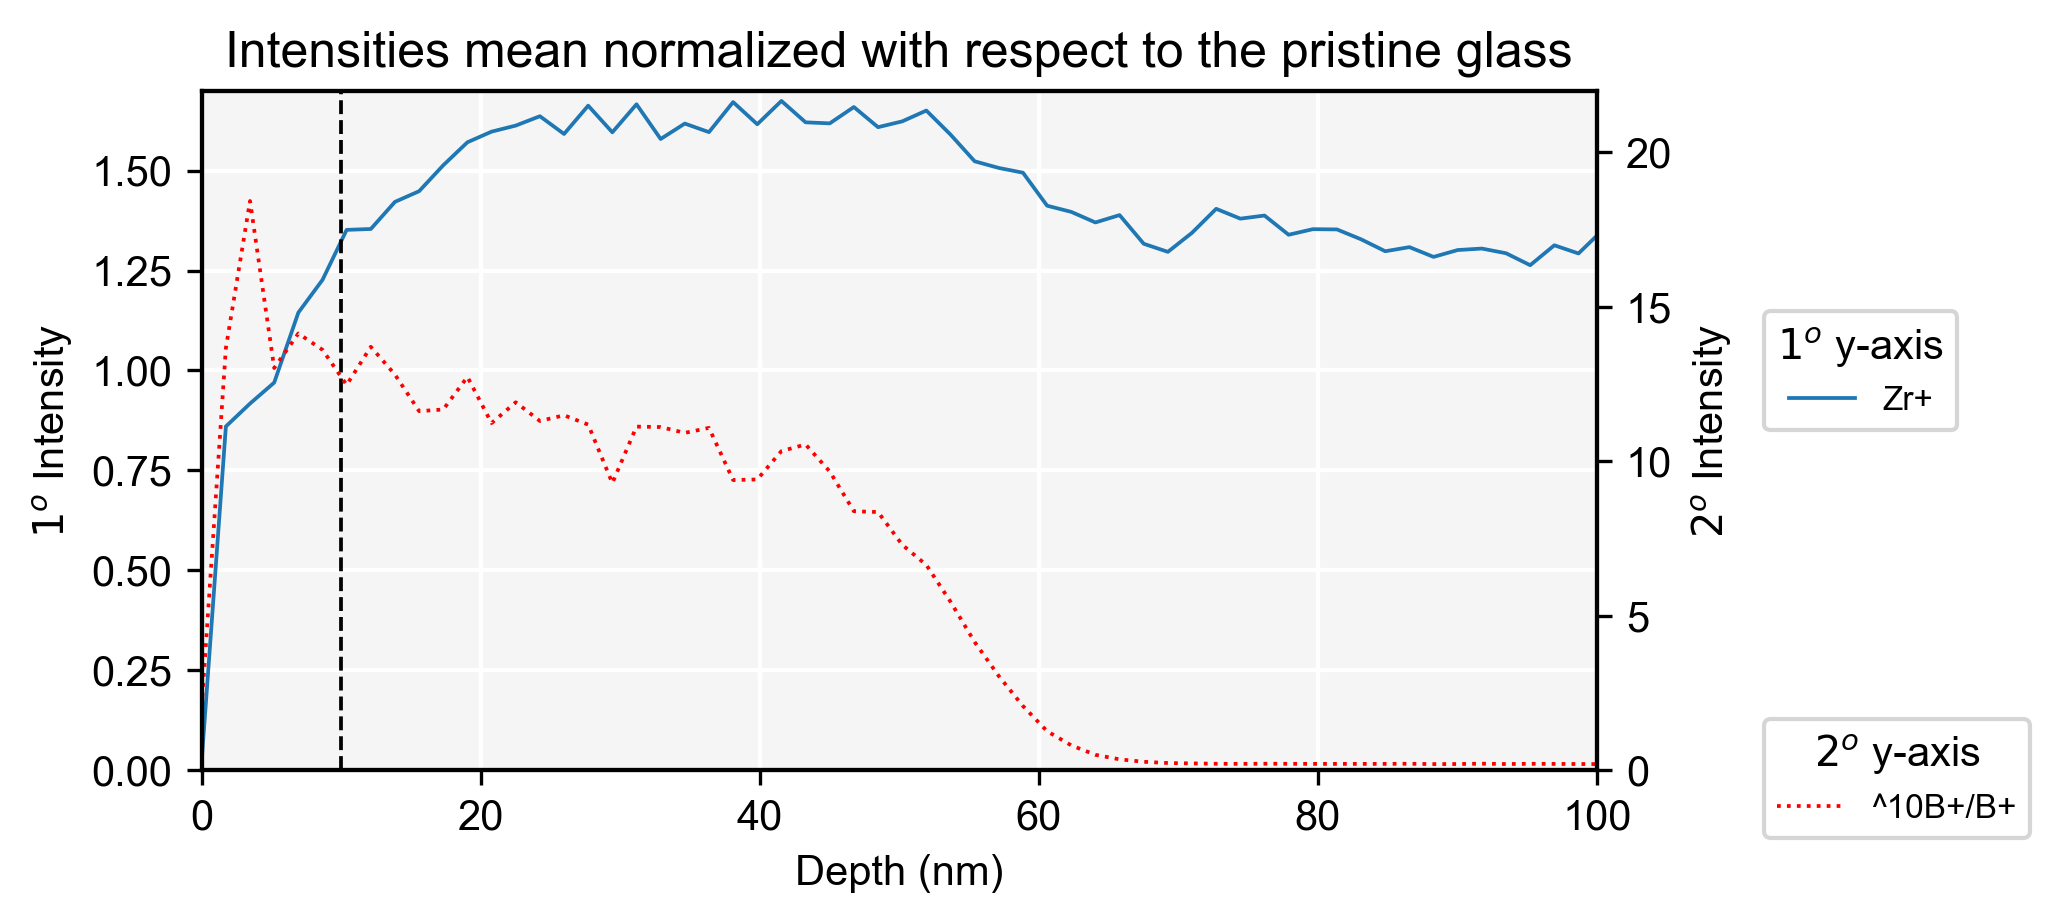

In [394]:
def mean_normalize_data(data):
    depth = data.get('depth')
    mean_normalized_data = { your_key: data[your_key] for your_key in ['file_name', 'depth'] }
    if list_of_elements_to_plot_in_primary_y_axis != []:
        dict_mean_p2p = element_mean_intensity_pristine_glass(data.get('primary_axis_elements'), depth)
        mean_normalized_data['primary_axis_elements'] = dict_mean_p2p.get('depth_wise_mean_normalized_data')
    if list_of_elements_to_plot_in_secondary_y_axis != []:
        dict_mean_p2p_2nd = element_mean_intensity_pristine_glass(data.get('secondary_axis_elements'), depth)
        mean_normalized_data['secondary_axis_elements'] = dict_mean_p2p_2nd.get('depth_wise_mean_normalized_data')
    return mean_normalized_data

def element_normalize_data(data):
    depth = data.get('depth')
    element_normalized_data = { your_key: data[your_key] for your_key in ['file_name', 'depth'] }
    dict_element_mean_p2p = element_mean_intensity_pristine_glass(data.get('element_to_normalize'), depth).get('depth_wise_mean_normalized_data')
    if list_of_elements_to_plot_in_primary_y_axis != []:
        element_normalized = {}
        dict_primary_mean_p2p = element_mean_intensity_pristine_glass(data.get('primary_axis_elements'), depth)
        for lines3_1, lines3_2 in dict_primary_mean_p2p.get('depth_wise_mean_normalized_data').items():
            element_normalized[lines3_1] = np.array(lines3_2)/np.array(dict_element_mean_p2p.get(choose_element_to_normalize))
        element_normalized_data['primary_axis_elements'] = element_normalized
    if list_of_elements_to_plot_in_secondary_y_axis != []:
        element_normalized = {}
        dict_secondary_mean_p2p = element_mean_intensity_pristine_glass(data.get('secondary_axis_elements'), depth)
        for lines3_3, lines3_4 in dict_secondary_mean_p2p.get('depth_wise_mean_normalized_data').items():
            element_normalized[lines3_3] = np.array(lines3_4)/np.array(dict_element_mean_p2p.get(choose_element_to_normalize))
        element_normalized_data['secondary_axis_elements'] = element_normalized
    return element_normalized_data
    
def ratio_of_element_data(data):
    depth = data.get('depth')
    ratio_of_elements = data.get('ratio_of_elements')
    numerator = ratio_of_elements.get(ratio_of_element_numerator)
    denominator = ratio_of_elements.get(ratio_of_element_denominator)
    ratio = np.array(numerator)/np.array(denominator)
    if adjust_elemental_ratio_to_natural_abundance == 'yes':
        mean_intensity_of_pg = element_mean_intensity_pristine_glass(data.get('ratio_of_elements'), depth).get('pristine_glass_mean_values')
        mean_intensity_ratio_of_pg = mean_intensity_of_pg.get(ratio_of_element_numerator)/mean_intensity_of_pg.get(ratio_of_element_denominator)
        x2 = mean_intensity_ratio_of_pg/natural_abundance_of_ratio
        corrected_ratio_of_elements = ratio/x2
        return {'ratio_of_elements': corrected_ratio_of_elements}
    else:
        return {'ratio_of_elements': ratio}

def verify_mean_normalization(tof_sims_data):
    if pilot_mode != 'yes':
        if 'element_normalized' in type_of_plot or 'mean_normalized' in type_of_plot:
            depth = tof_sims_data.get('depth')
            if type_of_mean_normalization == 'partition':
                if mean_normalize_based_on_which_partition == 'last':
                    target_glass_start = depth[-1] - mean_normalize_based_on_number_of_layers
                    value_close_to_the_start_1 = min(depth, key=lambda x:abs(x-target_glass_start))
                    print('Mean normalization is performed against the pristine glass region from %s to the %s.' %(value_close_to_the_start_1, depth[-1]))
                if mean_normalize_based_on_which_partition == 'first':
                    target_glass_end = depth[0] + mean_normalize_based_on_number_of_layers
                    value_close_to_the_end_1 = min(depth, key=lambda x:abs(x-target_glass_end))
                    print('Mean normalization is performed against the pristine glass region from %s to the %s.' %(depth[0], value_close_to_the_end_1))
            if type_of_mean_normalization == 'start_end':
                value_close_to_the_start = min(depth, key=lambda x:abs(x-pristine_glass_start_region))
                start_2 = depth.index(value_close_to_the_start)
                print('The requested start value for defining the pristine glass at \'pristine_glass_start_region\' is %s; The closest value python has found is %s after searching through the ToF-SIMS data' %(pristine_glass_start_region, value_close_to_the_start))
                value_close_to_the_end = min(depth, key=lambda x:abs(x-pristine_glass_end_region))
                end_2 = depth.index(value_close_to_the_end)
                print('The requested end value for defining the pristine glass at \'pristine_glass_end_region\' is %s; The closest value python has found is %s after searching through the ToF-SIMS data' %(pristine_glass_end_region, value_close_to_the_end))            
                print('Therefore, mean normalization is performed against the pristine glass region from %s to the %s.' %(value_close_to_the_start, value_close_to_the_end))

def tof_sims_data_process(data):
    x17_1 = verify_mean_normalization(data)
    if 'raw_data' in type_of_plot:
        tof_sims_data_plot(data)
    if ('mean_normalized' in type_of_plot) and ('ratio_of_element' in type_of_plot):
        mean_normalized_dict = mean_normalize_data(data)
        ratio_of_element_dict = ratio_of_element_data(data)
        if axis_of_ratio_of_element_to_plot == 'primary':
            mean_normalized_dict.get('primary_axis_elements')['%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator)] = ratio_of_element_dict['ratio_of_elements']
        if axis_of_ratio_of_element_to_plot == 'secondary':
            if list_of_elements_to_plot_in_secondary_y_axis != []:
                mean_normalized_dict['secondary_axis_elements']['%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator)] = ratio_of_element_dict['ratio_of_elements']
            else:
                mean_normalized_dict['secondary_axis_elements'] = {'%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator): ratio_of_element_dict['ratio_of_elements']}
        tof_sims_data_plot(mean_normalized_dict)
    elif 'mean_normalized' in type_of_plot:
        mean_normalized_dict = mean_normalize_data(data)
        tof_sims_data_plot(mean_normalized_dict)
    if ('element_normalized' in type_of_plot) and ('ratio_of_element' in type_of_plot):
        element_normalized_dict = element_normalize_data(data)
        ratio_of_element_dict = ratio_of_element_data(data)
        if axis_of_ratio_of_element_to_plot == 'primary':
            element_normalized_dict.get('primary_axis_elements')['%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator)] = ratio_of_element_dict['ratio_of_elements']
        if axis_of_ratio_of_element_to_plot == 'secondary':
            if list_of_elements_to_plot_in_secondary_y_axis != []:
                element_normalized_dict.get('secondary_axis_elements')['%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator)] = ratio_of_element_dict['ratio_of_elements']
            else:
                element_normalized_dict['secondary_axis_elements'] = {'%s/%s' %(ratio_of_element_numerator, ratio_of_element_denominator): ratio_of_element_dict['ratio_of_elements']}
        tof_sims_data_plot(element_normalized_dict)
    elif 'element_normalized' in type_of_plot:
        element_normalized_dict = element_normalize_data(data)
        tof_sims_data_plot(element_normalized_dict)

if pilot_mode == 'yes':
    list_of_files = glob.glob('*.txt')
    for lines0_0 in list_of_files:
        tof_sims_data = tof_sims_file_process(lines0_0)
        tof_sims_data_process(tof_sims_data)
else:
    tof_sims_data = tof_sims_file_process(filename_to_process)
    tof_sims_data_process(tof_sims_data)


## Change the colormap for secondary y-axis